[View in Colaboratory](https://colab.research.google.com/github/avinsit123/Generative-models/blob/master/MNIST_GANs.ipynb)

In [3]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
#define the class for GANs
class GAN():
  def __init__(self):
    self.img_rows=28
    self.img_cols=28
    self.channels=1
    self.img_shape=(self.img_rows,self.img_cols,self.channels)
    self.latent_dims=100
    
    #build the discriminator
    self.discriminator=self.build_disc()
    self.discriminator.compile(loss="binary_crossentropy",optimizer=Adam(),metrics=['accuracy'])
    
    self.generator=self.gen_mod()
    
    #generator takes in noise
    z=Input(shape=(self.latent_dims,))
    img=self.generator(z)
    val=self.discriminator(img)
    self.discriminator.trainable=False
    
    self.combi=Model(z,val)
    self.combi.compile(loss='binary_crossentropy',optimizer=Adam())
    
    
  def gen_mod(self):
      Generator=Sequential()
      Generator.add(Dense(128*14*14,activation='relu',input_dim=self.latent_dims))
      Generator.add(BatchNormalization())
      Generator.add(Reshape([14,14,128]))
      Generator.add(UpSampling2D(size=(2,2)))
      Generator.add(Conv2D(8,(3,3),padding='same',activation='relu'))
      Generator.add(BatchNormalization())
      Generator.add(Conv2D(16,(3,3),padding='same',activation='relu'))
      Generator.add(BatchNormalization())
      Generator.add(Conv2D(1,(3,3),padding='same',activation='sigmoid'))
      Generator.compile(loss='binary_crossentropy',optimizer=Adam())
      Generator.summary()
      z=Input(shape=(self.latent_dims,))
      img=Generator(z)
      
      return Model(z,img)
    
  def build_disc(self):
      model=Sequential()
      model.add(Conv2D(28,(3,3),strides=2,input_shape=(self.img_rows,self.img_cols,self.channels,),padding='same',activation='relu'))
      model.add(Dropout(0.3))
      model.add(Conv2D(64,(3,3),strides=2,padding='same',activation='relu'))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dropout(0.3))
      model.add(Conv2D(12, kernel_size=3, strides=2, padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(0.25))
      model.add(Flatten())
      model.add(Dense(1,activation='sigmoid'))
      model.summary()
      img = Input(shape=(self.img_rows,self.img_cols,self.channels,))
      validity = model(img)

      return Model(img, validity)
    
  def train(self,epochs,batch_size=32,saves=30):
      
      (X_train,_),(_,_)=mnist.load_data()
      X_train=X_train.astype('float32')/255
      X_train=np.expand_dims(X_train,axis=3)
      
      valid=np.ones((batch_size,1))
      fake=np.zeros((batch_size,1))
      
      
      for run in range(epochs):
        idx=np.random.randint(1,X_train.shape[0],batch_size)
        imgs=X_train[idx]
        #imgs=imgs.reshape(self.img_rows,self.img_cols,self.channels,batch_size)
                
        
        noise = np.random.normal(0, 1, (batch_size, self.latent_dims))
        gen_img=self.generator.predict(noise)
        
        
        loss_real=self.discriminator.train_on_batch(imgs,valid)
        loss_fake=self.discriminator.train_on_batch(gen_img,fake)
        loss=(np.asarray(loss_real)+np.asarray(loss_fake))/2
        
        genloss=self.combi.train_on_batch(noise,valid)
        
        #Sample some noise
        if(run%500==0):
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (run, loss[0], 100*loss[1], genloss))
    
    

In [54]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


Redirecting output to ‘wget-log’.
Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [55]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://79e78b99.ngrok.io


In [5]:

dcgan=GAN()
dcgan.train(4000)
print(dcgan.img_cols)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 28)        280       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          16192     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 12)          6924      
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 12)          48        
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.901083, acc.: 48.44%] [G loss: 0.948172]
500 [D loss: 0.116317, acc.: 96.88%] [G loss: 2.584510]
1000 [D loss: 0.160664, acc.: 96.88%] [G loss: 2.854530]
1500 [D loss: 0.678483, acc.: 65.62%] [G loss: 3.550833]
2000 [D loss: 0.426986, acc.: 78.12%] [G loss: 3.079059]
2500 [D loss: 0.179412, acc.: 96.88%] [G loss: 1.708482]
3000 [D loss: 0.071614, acc.: 98.44%] [G loss: 1.631464]
3500 [D loss: 0.604156, acc.: 64.06%] [G loss: 2.189312]
28


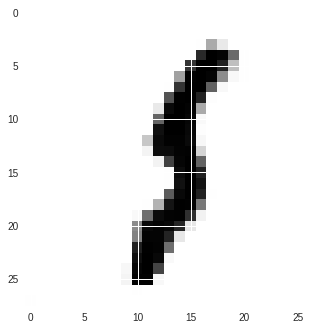

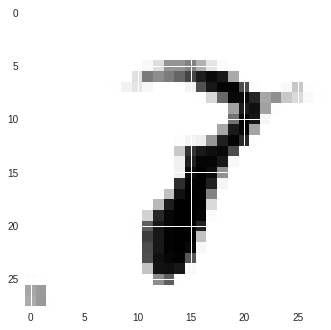

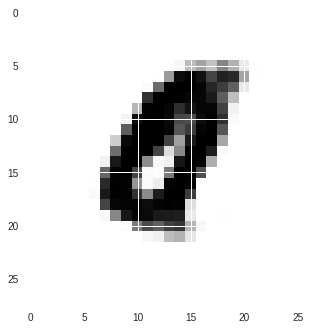

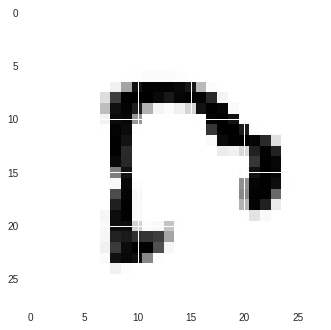

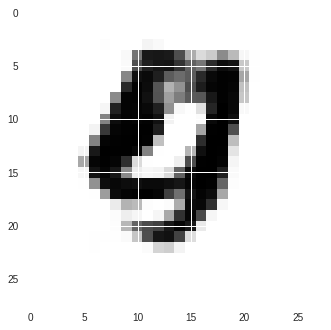

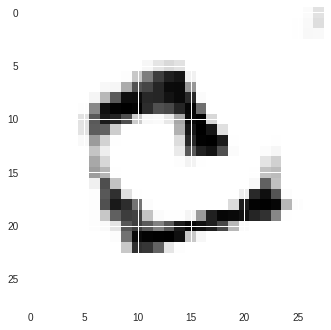

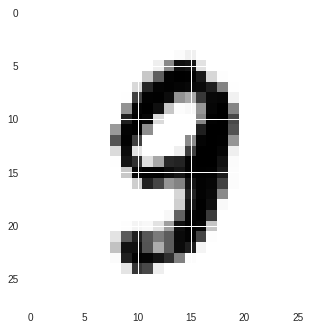

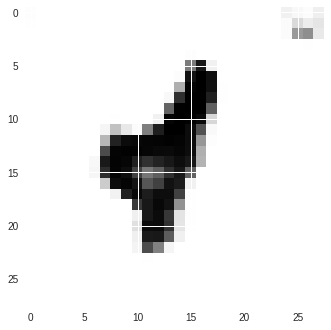

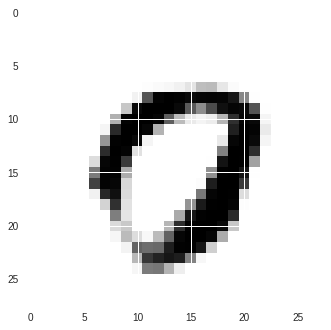

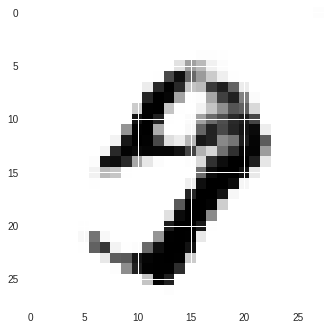

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

for i in range(10):
  img=dcgan.generator.predict(np.random.normal(0, 1, (1, 100)))
  plt.imshow(img.reshape(28,28))
  plt.show()


We can clearly see that our generator is trying to generate certain MNIST digits by itself.However GANs being notoriously difficult to train take lots of time for training and hence the distorted images.